## Checking available files in dataset

Adding metadata from image file

In [1]:
import os
from PIL import Image
import pandas as pd
from typing import Tuple

In [2]:
def check_files(datapath:str, savepath:str=None)-> Tuple[pd.DataFrame,list]:
    """ Runs through the data folder and obtain metadata from the image
    Args:
        datapath (str): path to data folder
        savepath (str, optional): path to csv dataframe to save. Defaults to None.
    Returns:
        pd.DataFrame: dataframe of image 
        list: list of erroneous files
    """    
    path, mode, size, form, error_ls = [], [], [], [], []
    for root, _, files in os.walk(datapath):
        for file in files:
            filepath = os.path.join(root, file)
            if check_file_extension(filepath):
                img = Image.open(filepath)
                try:
                    path.append(filepath)
                    mode.append(img.mode)
                    size.append(img.size)
                    form.append(img.format)
                except:
                    error_ls.append(filepath)

    df = pd.DataFrame.from_dict({'file_path': path, 'img_size': size, 'img_mode':mode, 'img_format':form})

    if savepath: 
        df.to_csv(savepath, index=False)

    return df, error_ls

def check_file_extension(file:str)->bool:
    """ Check for file extension
    Returns:
        Bool: True if jpeg or jpg
    """
    fileext = os.path.splitext(file)[1]
    if fileext == ".jpeg" or fileext ==".jpg":
        return True
    return False


In [3]:
datapath = "../data" 
savepath = "dataset.csv"

df, error = check_files(datapath, savepath)
print(f"Dataset consist of length {df.shape[0]} with {df.shape[1]} columns.")
print(f"Number of erroneous files is {len(error)}.")

Dataset consist of length 5856 with 4 columns.
Number of erroneous files is 0.


In [4]:
df.head()

,file_path,img_size,img_mode,img_format
0,../data/val/NORMAL/NORMAL2-IM-1431-0001.jpeg,"(1736, 1416)",L,JPEG
1,../data/val/NORMAL/NORMAL2-IM-1440-0001.jpeg,"(1632, 1225)",L,JPEG
2,../data/val/NORMAL/NORMAL2-IM-1442-0001.jpeg,"(1564, 1302)",L,JPEG
3,../data/val/NORMAL/NORMAL2-IM-1436-0001.jpeg,"(1288, 928)",L,JPEG
4,../data/val/NORMAL/NORMAL2-IM-1430-0001.jpeg,"(1272, 1040)",L,JPEG


## Parsing Folder data

In [5]:
import pandas as pd

savepath = "dataset.csv"
df = pd.read_csv(savepath)

In [6]:
def get_tts(path:str)->str:
    tts = path.split('/')[2]
    return tts

def get_class(path:str)->str:
    folder = path.split('/')[3]
    return folder

# Obtain Class and If dataset is from Train, Test or Validation folder
df['tts'] = df.file_path.apply(lambda x: get_tts(x))
df['class'] = df.file_path.apply(lambda x: get_class(x))

def get_type(path:str)->str:
    type = path.split('/')[-1].split('_')[1]
    return type

# Obtain Type of Pneumonia, "Bacterial" or "Viral" if class is Pneumonia
subset = df.loc[df["class"]=="PNEUMONIA", ["file_path", "class"]].copy()
subset["type"] = subset.file_path.apply(lambda x: get_type(x))
df = df.merge(subset, how="inner", left_on="file_path", right_on="file_path")
df.drop(columns="class_y", inplace=True)
df.rename(columns={"class_x": "class"}, inplace=True)

savepath = "dataset.csv"
df.to_csv(savepath, index=False)


In [7]:
df.head()

,file_path,img_size,img_mode,img_format,tts,class,type
0,../data/val/PNEUMONIA/person1946_bacteria_4875...,"(1072, 712)",L,JPEG,val,PNEUMONIA,bacteria
1,../data/val/PNEUMONIA/person1954_bacteria_4886...,"(1664, 1128)",L,JPEG,val,PNEUMONIA,bacteria
2,../data/val/PNEUMONIA/person1951_bacteria_4882...,"(1016, 656)",L,JPEG,val,PNEUMONIA,bacteria
3,../data/val/PNEUMONIA/person1952_bacteria_4883...,"(1192, 952)",L,JPEG,val,PNEUMONIA,bacteria
4,../data/val/PNEUMONIA/person1947_bacteria_4876...,"(1152, 664)",L,JPEG,val,PNEUMONIA,bacteria


## EDA

In [8]:
import pandas as pd
import seaborn as sns

In [9]:
df = pd.read_csv('dataset.csv')
df.shape

(4273, 7)

Text(0.5, 1.0, 'Cases of Bacteria vs Viruses')

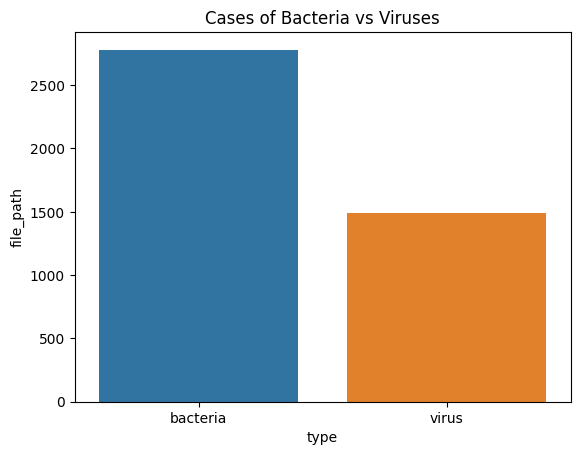

In [10]:
class_df = df.groupby('type').count().reset_index()
class_df["pct_bacteria_vs_virus"] = (class_df["file_path"]/class_df["file_path"].sum())*100
class_df
sns.barplot(class_df, x="type", y="file_path").set_title("Cases of Bacteria vs Viruses")

Text(0.5, 1.0, 'Image modes (RGB vs Greyscale)')

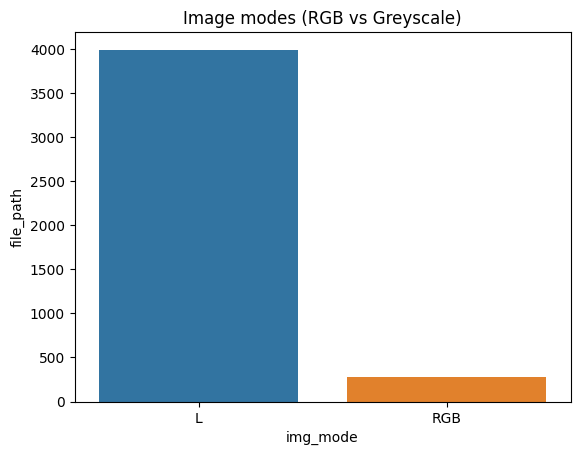

In [11]:
mode_df = df.groupby('img_mode').count().reset_index()
sns.barplot(mode_df, x="img_mode", y="file_path").set_title("Image modes (RGB vs Greyscale)")


Text(0.5, 1.0, 'Images by folder (train test or validation)')

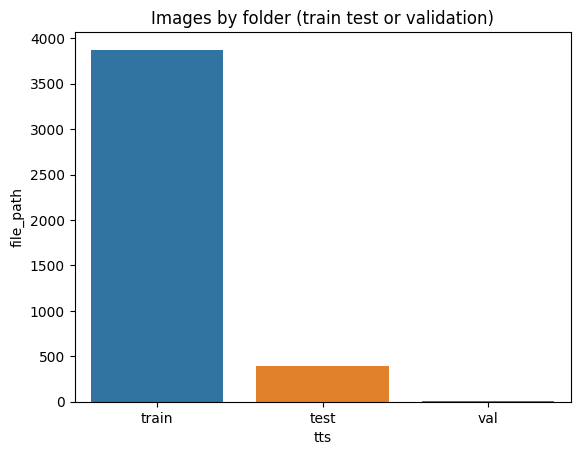

In [13]:
tts_df = df.groupby('tts').count()["file_path"].reset_index()
order_df = tts_df.sort_values("file_path",ascending=False)
sns.barplot(tts_df, x="tts", y="file_path", order=order_df["tts"]).set_title("Images by folder (train test or validation)")